In [1]:
from __future__ import division
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
def kernel(X_1,X_2, sigma = 1):
    """
    INPUT:
        X_1: N*D np.array
        X_2: N*D np.array
    OUTPUT:
        N*N np.array
    """
    square_distance = np.sum(X_1 ** 2, 1).reshape(-1,1) + np.sum (X_2 ** 2, 1) \
                        - 2 * np.dot(X_1, X_2.T)
    return np.exp(- 0.5 * square_distance)

In [3]:
n_predict = 50 # number of datapoints to predict
n_observed = 10 # number of datapoints observed
n_gp_samples = 10 # number of samples from GP
s = 0.0005 # noise added to kernel matrix

In [4]:
X_test = np.linspace(-5, 5, n_predict).reshape(-1,1) # test points

# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(0.9*x).flatten()
X = np.random.uniform(-5, 5, size=(n_observed,1))
y = f(X) + s*np.random.randn(n_observed)

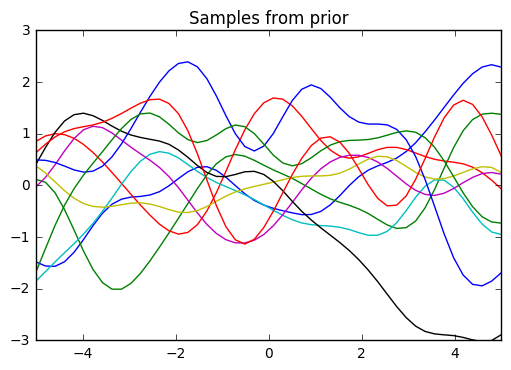

In [8]:
# sample from prior
# It assumes a zero mean GP Prior
K_ = kernel(X_test, X_test) # kernel at test points
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n_predict))

f_prior  = np.dot(L, np.random.normal(size=(n_predict, n_gp_samples)))
plt.plot(X_test, f_prior)
plt.title("Samples from prior")
plt.axis([-5, 5, -3, 3])
plt.savefig('figures/gp_demo_prior.png', bbox_inches='tight')

In [9]:
# Observe the data: suppose the corresonding y value of X_test are observed
K = kernel(X, X)
L = np.linalg.cholesky(K + s*np.eye(n_observed))

Lk = np.linalg.solve(L, kernel(X, X_test))
mu = np.dot(Lk.T, np.linalg.solve(L, y))

s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
s = np.sqrt(s2)

[-5, 5, -3, 3]

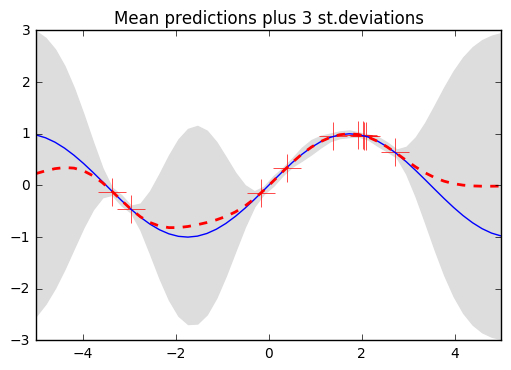

In [11]:
# PLOTS:
plt.plot(X, y, 'r+', ms=20)
plt.plot(X_test, f(X_test), 'b-')
plt.gca().fill_between(X_test.flat, mu-3*s, mu+3*s, color="#dddddd")
plt.plot(X_test, mu, 'r--', lw=2)
plt.savefig('figures/gp_demo_predictive.png', bbox_inches='tight')
plt.title('Mean predictions plus 3 st.deviations')
plt.axis([-5, 5, -3, 3])

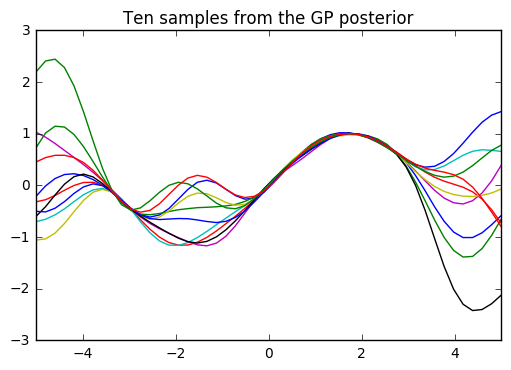

In [12]:
# draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n_predict) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n_predict,10)))
plt.clf()
plt.plot(X_test, f_post)
plt.title('Ten samples from the GP posterior')
plt.axis([-5, 5, -3, 3])
plt.savefig('figures/gp_demo_posterior.png', bbox_inches='tight')